In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
base_dir = '/tmp'
zip_ref = zipfile.ZipFile("/content/drive/My Drive/lung_colon_image_set.zip", 'r')
zip_ref.extractall(base_dir)
zip_ref.close()

In [ ]:
import shutil
original = base_dir + '/lung_colon_image_set/colon_image_sets'
target = '/content/lung_colon'

shutil.copytree(original, target)

original = base_dir + '/lung_colon_image_set/lung_image_sets'

!cp -R /tmp/lung_colon_image_set/lung_image_sets/* /content/lung_colon

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_dir = '/content/lung_colon/'
datagen_colon = ImageDataGenerator(validation_split = 0.2, 
        rescale=1 / 255.0, # RGB coefficients in the 0-255, it would be too high for our model to process, so we target values between 0 and 1 instead by scaling with a 1/255
        rotation_range=0.0, # Random Rotations
        zoom_range=0.0, # Random Zoom
        width_shift_range=0.0, # Random Shifts
        height_shift_range=0.0, # Random Shifts
        shear_range=0.0,
        horizontal_flip=False) # Random Flips

BATCH_SIZE = 32

X = Y = 128

training = datagen_colon.flow_from_directory(data_dir,
                                    class_mode = "categorical", # 2D
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, # Size of the batches of data.
                                    shuffle = True,
                                    subset='training',
                                    seed = 42) # Set to reproduce the result.

validation = datagen_colon.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = True,
                                      subset='validation',
                                      seed = 42)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


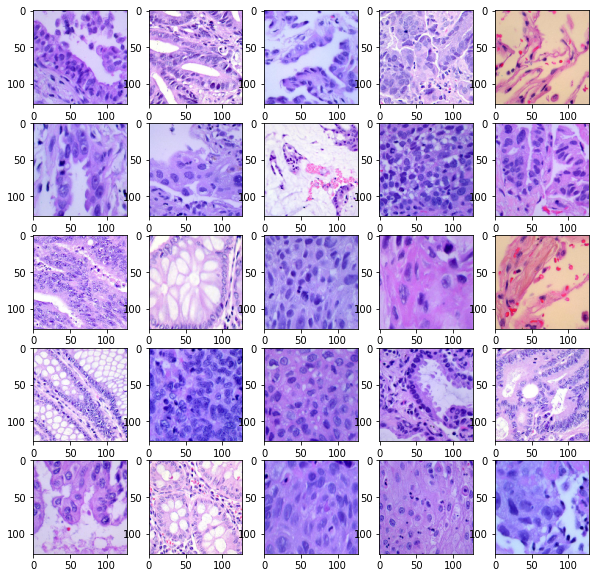

In [ ]:
plt.gcf().set_size_inches(10, 10)
for x_batch, y_batch in training: # print image
    for i in range(0, 25):
        plt.subplot(5, 5, i+1)
        plt.imshow(x_batch[i].reshape(X, Y, 3))
    break

In [ ]:
input_shape = training.image_shape
num_classes = training.num_classes
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding = 'Same'))
model.add(Conv2D(32, kernel_size=(3, 3),  activation ='relu', padding = 'Same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3,3), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (3,3), activation ='relu', padding = 'Same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#model.add(Conv2D(128, kernel_size = (3,3), activation ='relu', padding = 'Same'))
#model.add(Conv2D(128, kernel_size = (3,3), activation ='relu', padding = 'Same'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
#from keras.models import load_model
#model = load_model('/content/model-001-0.682800-0.811600.h5')

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 64)        36928     
                                                      

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', 
                             verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, 
                             mode='min')  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [ ]:
epochs = 100
batch_size = 64
history = model.fit(training, 
                    epochs=epochs,  # one forward/backward pass of training data
                    batch_size = batch_size,
                    validation_data=validation,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.8341 - accuracy: 0.6084
Epoch 1: val_loss improved from inf to 0.57065, saving model to model-001-0.608400-0.739800.h5
625/625 [==============================] - 245s 391ms/step - loss: 0.8341 - accuracy: 0.6084 - val_loss: 0.5706 - val_accuracy: 0.7398
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.7872
Epoch 2: val_loss improved from 0.57065 to 0.36337, saving model to model-002-0.787200-0.866800.h5
625/625 [==============================] - 246s 393ms/step - loss: 0.4781 - accuracy: 0.7872 - val_loss: 0.3634 - val_accuracy: 0.8668
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.8587
Epoch 3: val_loss improved from 0.36337 to 0.23542, saving model to model-003-0.858650-0.900000.h5
625/625 [==============================] - 245s 392ms/step - loss: 0.3496 - accuracy: 0.8587 - val_loss: 0.2354 - val_accuracy: 0.9000
Epoch 4/100

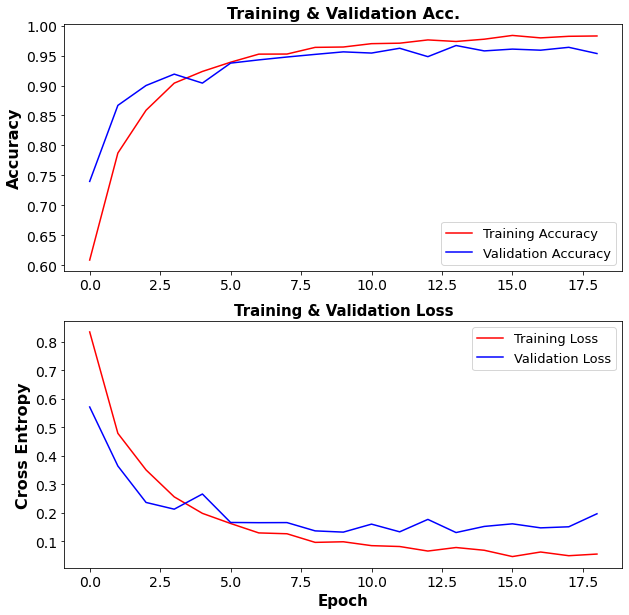

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

Epoch 14: val_loss improved from 0.13124 to 0.12976

then start to overfit

In [ ]:
test_loss, test_acc = model.evaluate(validation)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

157/157 [==============================] - 49s 307ms/step - loss: 0.1298 - accuracy: 0.9668
Test loss: 0.12976229190826416 Test Acc: 0.9667999744415283


In [ ]:
from sklearn.metrics import classification_report

v1 = datagen_colon.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)
# the shuffle parameter is True by default, 
# because of which the predictions didn't correspond to the ground truth.
# Setting shuffle=False solved the problem.
Y_pred = model.predict(v1)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

Found 5000 images belonging to 5 classes.
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      1.00      0.99      1000
           2       0.94      0.91      0.92      1000
           3       0.98      1.00      0.99      1000
           4       0.93      0.94      0.93      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

